# Trabalho final NeuroComputação 

## Aluno : Daniel Farkat 

## Matrícula:166106/2024

Este trabalho se divide em três partes, na primeira é feita a parte de pré processamento, na segunda se processam os dados e na terceira são apresentados os resultados encontrados 

![imagem de referência do organograma](fluxograma.drawio.png)

# Em suma qual o objetivo 

O objetivo deste estudo é avaliar os resultados visuais da emplementação de dados de séries temporais como mecanismo de agrupamento de dados de áreas que sofreram com queimada. Então são identificados os pontos de queimada assim como a série temporal tanto destes pontos como de alguns de seus vizinhos que não representam queimada como pode ser visto na imagem. 

In [ ]:
# A data escolhida foi de 13/09 de 2022 até o dia 17 pois durante o ano de 2022 foram o intervalo temporal com mais focos de incêndio  foram mais de 1000 focos levando em consideradação os dados do programa queimadas do INPE 

# A baixo é apresentado o código para extrair os dados de série temporal pois precisamos retirar núvens e para isso interpolamos valores

import pandas as pd
from scipy import signal, interpolate
import numpy as np
from matplotlib import pyplot as plt
import wtss
import tqdm

servico = wtss.WTSS('https://data.inpe.br/bdc/wtss/v4/')
servico.coverages

cubo_s2 = servico['S2-16D-2']

timeline = cubo_s2.timeline

ultima_data_disponivel = timeline[0]
primeira_data_disponivel = timeline[-1]

print(f'Intervalo: [{primeira_data_disponivel}, {ultima_data_disponivel}]')

nbr_values = []
scl_values = []

for id, geometry in tqdm.tqdm(zip(pontos.id_ponto.values,
                                  pontos.geometry.values),
                         desc="Processando dados", unit="data"):

    timeseries = cubo_s2.ts(attributes=attributes,
                            geom=geometry,
                            start_date=start_date,
                            end_date=end_date)
    
    tmp = timeseries.df('nbr')   

    nbr_values.append(tmp.loc[tmp.attribute == 'nbr', 'value'])
    scl_values.append(tmp.loc[tmp.attribute == 'SCL', 'value'])

nbr = pd.DataFrame(data=np.asarray(nbr_values).T,
                    columns=pontos.id_ponto.values,
                    index=timeseries.ts.timeline)

nbr = nbr.reset_index().rename(columns={'index': 'data'})

nbr.to_csv('nbr_sample_v2.csv')

scl = pd.DataFrame(data=np.asarray(scl_values).T,
                    columns=pontos.id_ponto.values,
                    index=timeseries.ts.timeline)

scl = scl.reset_index().rename(columns={'index': 'data'})

scl.to_csv(base_dir + 'scl_sample_v2.csv')

def filter(nbr, cond):
    length = len(nbr)
    filtered_nbr = nbr.copy()
    filtered_nbr = filtered_nbr[cond]
    x = np.linspace(0, length-1, num=length)
    x = x[cond]
    return length, x, filtered_nbr

def interpol(x, filtered_nbr, length, spline=False):
    new_x = np.linspace(0, length-1, num=length)
    if spline:
        slp = interpolate.CubicSpline(x, filtered_nbr)
        return slp(new_x)
    return np.interp(new_x, x, filtered_nbr)

def merge_nbr(nbr, gol_nbr):
    cond = nbr > gol_nbr
    final_nbr = gol_nbr.copy()
    final_nbr[cond] = nbr[cond]
    return final_nbr

def compute_f_metric(ref_nbr, gol_nbr):
    dist = np.abs(gol_nbr - ref_nbr)
    max_dist = np.max(dist)
    w = np.ones(shape=dist.shape)
    cond = gol_nbr > ref_nbr
    w[cond] = 1 - dist[cond] / max_dist
    return np.dot(dist, w)

def restore_nbr(nbr, cond):
    length, x, filtered_nbr = filter(nbr, cond)
    inter_nbr = interpol(x, filtered_nbr, length, spline=True)
    gol_nbr = signal.savgol_filter(inter_nbr, 5, 3)
    final_nbr = merge_nbr(nbr, gol_nbr)
    return final_nbr

path_nbr = 'nbr_sample_v3.csv'
path_scl = 'scl_sample_v3.csv'

nbr_data = pd.read_csv(path_nbr, index_col=0, parse_dates=['data'])
scl_data = pd.read_csv(path_scl, index_col=0)

new_nbr = pd.DataFrame({'data': nbr_data.data})

for col in nbr_data.drop(columns=['data']).columns:
    nbr = nbr_data[col].values
    scl = scl_data[col].values

    cond = (scl >= 4) & (scl <= 7)

    nbr_normalized = (nbr + 1) / 2 * 20000 - 10000
    nbr_normalized = nbr_normalized.astype(int)

    restored_nbr = np.where(cond, nbr_normalized, np.nan)
    restored_nbr = np.nan_to_num(restored_nbr, nan=0)

    temp_df = pd.DataFrame(restored_nbr, columns=[col])
    temp_df[col] = temp_df[col].replace(0, np.nan)
    temp_df[col] = temp_df[col].interpolate(method='linear', limit_direction='both')
    temp_df[col] = temp_df[col].fillna(0).astype(int)

    new_nbr[col] = temp_df[col]
    print(new_nbr[col])

new_nbr.to_csv('data/filtered_filled_nbr_sample_interpolado_v3.csv', index=False)



# Após salvar as imagens

Como necessário precisamos plotar as imagens para entender se o pensamento a priori de que as séries temporias teriam uma rampa negativa e depois um crescimento constante indicando a queda causada por uma queimada e o retorno da vegetação causado pela resiliencia da vegetação 

no qual para os pontos amostrados a baixo 

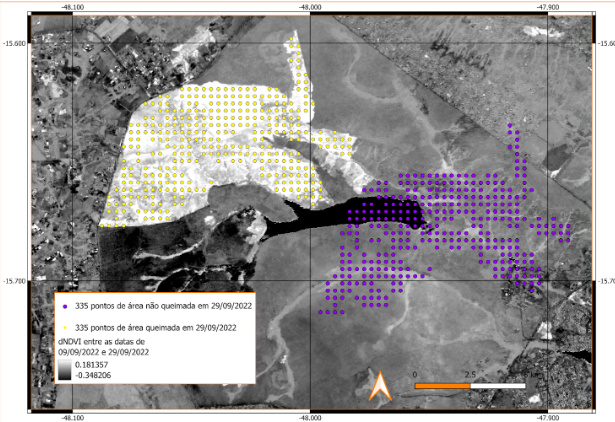

Essas são as séries temporias 

encontradas

# Para o caso contendo uma queimada na série temporal

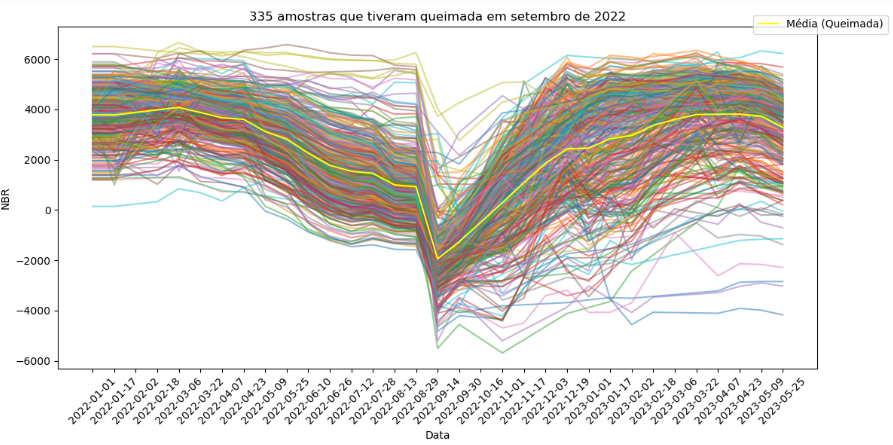

# Para o caso que não contem queimadas na série temporal 

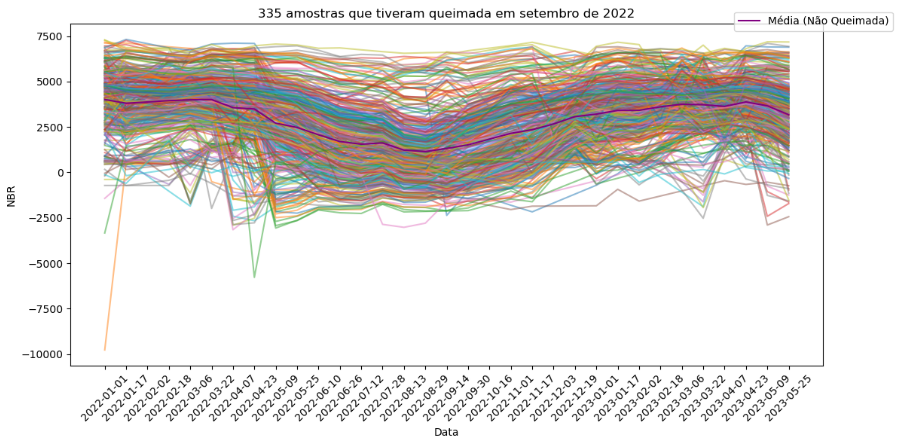

# Observação:

Plotei de amarelo representando queimada e de roxo as médias para poder ficar mais claro com a imagem quem representa quem nas séries temporais 

A seguir é demonstrado o código que faz isso 

In [ ]:
# este código foi o código que pegou como entrada as informações e plotou no gráfico as listas perceba que eu colocoquei na primeira coluna as datas e em seguida as queimadas como os primeiros 335 amostras e as nào queimadas como as 335 seguintes

import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('data/filtered_filled_nbr_sample_interpolado_v3.csv', header=None, skiprows=1)

date = df.iloc[:, 0]

first_335_samples = df.iloc[:, 1:336]
second_335_samples = df.iloc[:, 335:670]

mean_first_335 = first_335_samples.mean(axis=1)
std_first_335 = first_335_samples.std(axis=1)
var_first_335 = first_335_samples.var(axis=1)

mean_second_335 = second_335_samples.mean(axis=1)
std_second_335 = second_335_samples.std(axis=1)
var_second_335 = second_335_samples.var(axis=1)

plt.figure(figsize=(12, 6))

for i in range(first_335_samples.shape[1]):
    plt.plot(date, first_335_samples.iloc[:, i], alpha=0.5)

plt.plot(date, mean_first_335, color='yellow', label='Média (Queimada)')
plt.fill_between(date, mean_first_335 - std_first_335, mean_first_335 + std_first_335, color='red', alpha=0.2)

plt.xlabel('Data')
plt.ylabel('NBR')
plt.title('335 amostras de queimada')
plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.05))
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

plt.figure(figsize=(12, 6))

for i in range(second_335_samples.shape[1]):
    plt.plot(date, second_335_samples.iloc[:, i], alpha=0.5)

plt.plot(date, mean_second_335, color='purple', label='Média (Não Queimada)')
plt.fill_between(date, mean_second_335 - std_second_335, mean_second_335 + std_second_335, color='blue', alpha=0.2)

plt.xlabel('Data')
plt.ylabel('NBR')
plt.title('335 amostras de não queimada')
plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.05))
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()


# Teste com a som 

Com os dados salvos e visuais foram testadas as redes não supervisionadas como na literatura existe um custume de começar com a técnica de aprendizado competitivo e foi uma área que vi sendo desenvolvida como em [artigo](http://brazildatacube.org/wp-content/uploads/2020/06/202007_ICCSA-2020-MALSEOD-Camera_Ready_Adeu-etal.pdf) como [nessa tese](mtc-m21c.sid.inpe.br/col/sid.inpe.br/mtc-m21c/2020/08.03.21.55/doc/publicacao.pdf)

Porem foram utilizados os dados de séries temporias para fazer a clusterizaçao e não os dados das matrizes raster e em seguida o processamento de dados 

# Resultado com uma som que possuia média centrada em zero e tendo o tamanho dos dados de referência ou seja uma som com 34 neurônios pois minha série temporal tem 34 amoostras 

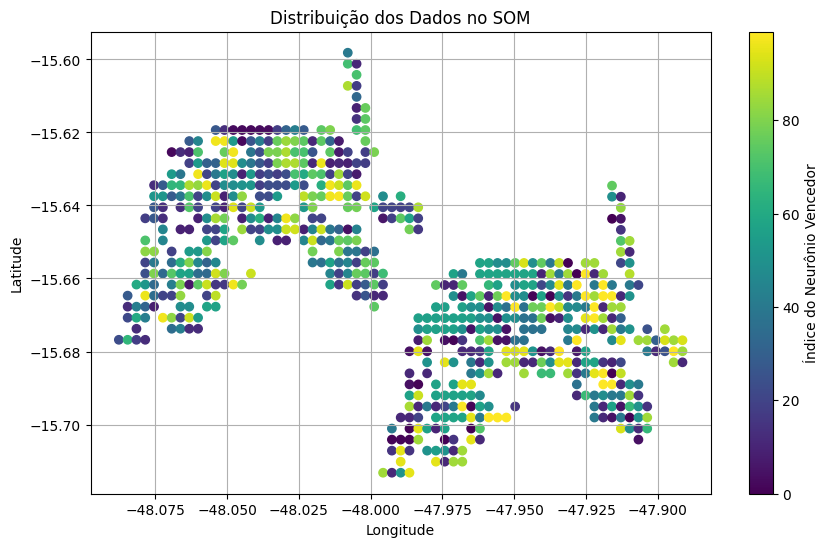

In [ ]:
import pandas as pd
import numpy as np
from minisom import MiniSom
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

file_path = 'arquivodereferenciaondesalveionbr.csv'
df = pd.read_csv(file_path)

date_columns = df.columns[4:]
data_values = df[date_columns].values
coordinates = df[['long', 'lat']].values

scaler = StandardScaler()
data_values_scaled = scaler.fit_transform(data_values)

som_size = 10
som = MiniSom(som_size, som_size, data_values_scaled.shape[1], sigma=1.0, learning_rate=0.05)

def calculate_errors(som, data_values_scaled):
    quantization_errors = np.zeros(len(data_values_scaled))
    topographic_errors = np.zeros(len(data_values_scaled))
    
    for i, x in enumerate(data_values_scaled):
        winner = som.winner(x)
        winner_weights = som.get_weights()[winner[0], winner[1]]
        quantization_errors[i] = np.linalg.norm(x - winner_weights)
        
        distances = np.linalg.norm(data_values_scaled - winner_weights, axis=1)
        sorted_distances = np.sort(distances)
        topographic_errors[i] = sorted_distances[1] - sorted_distances[0]
    
    return quantization_errors, topographic_errors

q_errors = []
t_errors = []

epocas = 100

for epoch in range(epocas):
    som.train_batch(data_values_scaled, 1)
    quantization_error, topographic_error = calculate_errors(som, data_values_scaled)
    q_errors.append(np.mean(quantization_error))
    t_errors.append(np.mean(topographic_error))

plt.figure(figsize=(12, 6))
plt.plot(np.arange(epocas), q_errors, label='Erro Quantização')
plt.plot(np.arange(epocas), t_errors, label='Erro Topográfico')
plt.ylabel('Erro')
plt.xlabel('Épocas')
plt.title('Evolução dos Erros Durante o Treinamento do SOM')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
scatter = plt.scatter(df['long'], df['lat'], c=[som.winner(x)[0] * som_size + som.winner(x)[1] for x in data_values_scaled], cmap='viridis', marker='o')
plt.colorbar(scatter, label='Índice do Neurônio Vencedor')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Distribuição dos Dados no SOM')
plt.grid(True)
plt.show()


# Para plotar as métricas da SOM

In [ ]:
# Criando as variaveis que servem de entrada

x = data.drop(['target'], axis=1)
target=data['target'].values

import seaborn as sns
import matplotlib.pyplot as plt

# U-matrix

plt.figure(figsize=(5,5),dpi=100)
plt.imshow(som.distance_map(), cmap='Blues')
plt.title('U-Matrix')
plt.colorbar()
plt.show()


#Heatmap

hits = som.activation_response(x.values).astype(int)
# hits = hits.T[::-1]
plt.figure(figsize=(5, 5),dpi=100)
plt.imshow(hits,cmap='Reds')
plt.colorbar()
for (i, j), value in np.ndenumerate(hits):
          plt.text(j, i, value, horizontalalignment='center', verticalalignment='center')

plt.title('Hitmap')
plt.show()


# Teste com kmeans

Neste teste tentei utilizar uma técnica mais clássica de agrupamento e pensei em fazer  a busca de média entre uma quantidade de clusters pré definido e por isso eu testei para ir variando os valores de cluster até que quando eu passei de 3 clusters os agrupamentos começavam a se confudir mas ainda assim o resultado não era tão próximo do que si imaginava como resultado correto no ínicio. 

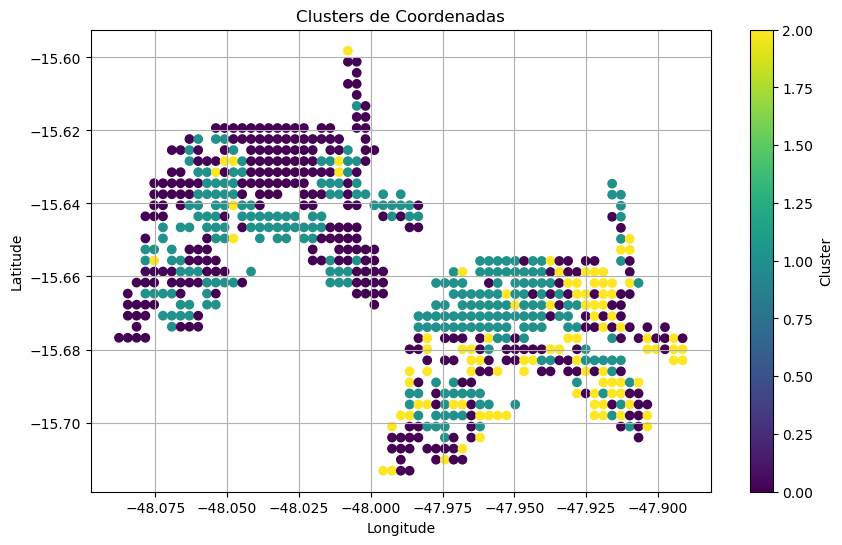

In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

coordinates_file_path = 'nbr_with_lat_long.csv'
coordinates_df = pd.read_csv(coordinates_file_path)

latitudes = coordinates_df['lat']
longitudes = coordinates_df['long']

num_clusters = 3 # quando foi a cima disso ficou dificil visualizar nas coordenadas os valores esse nbr with latlong coloquei nas primeiras colunas uma coluna chamada lat e outra chamada long para salvar nelas as informações de cordenadas para poder plotar no mapa
kmeans = KMeans(n_clusters=num_clusters)
clusters = kmeans.fit_predict(coordinates_df[['lat', 'long']])

coordinates_df['Cluster'] = clusters

plt.figure(figsize=(10, 6))
scatter = plt.scatter(coordinates_df['long'], coordinates_df['lat'], c=coordinates_df['Cluster'], cmap='viridis')
plt.colorbar(label='Cluster')
plt.title('Clusters por Coordenadas')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


# Teste com PCA aplicado em k-means

o seguinte teste foi realizado com o kmeans novamente porem com o diferêncial de tentar plotar com os dados de pca e testado parea ver os resultados e comparar com o uso de kmeans somente. No final das contas o resultado foi o mesmo mas podemos ver os klusters bem definidos no plot das componetes principais em que se tem 3 classes bem definidas 

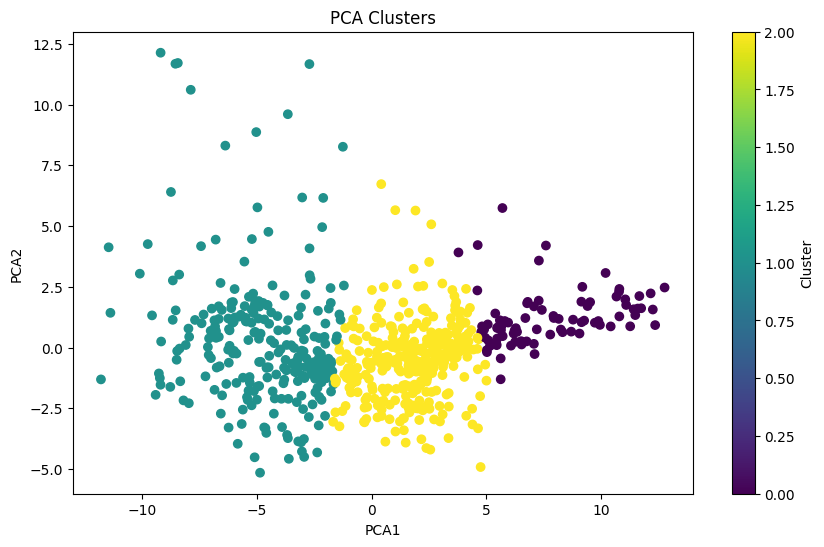


In [ ]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

file_path = 'nbr_with_lat_long.csv'
df = pd.read_csv(file_path)

date_columns = df.columns[4:]
data_values = df[date_columns].values

scaler = StandardScaler()
data_values_scaled = scaler.fit_transform(data_values)

pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_values_scaled)

num_clusters = 3
kmeans = KMeans(n_clusters=num_clusters)
clusters = kmeans.fit_predict(data_pca)

df['Cluster'] = clusters
df['PCA1'] = data_pca[:, 0]
df['PCA2'] = data_pca[:, 1]

print("Classes dos clusters:", list(df['Cluster']))

plt.figure(figsize=(10, 6))
plt.scatter(df['PCA1'], df['PCA2'], c=df['Cluster'], cmap='viridis')
plt.colorbar(label='Cluster')
plt.title('PCA Clusters')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.show()


# Resultado plotado em coordenadas espaciais 

Foi plotado o resultado no mapa que resultou na seguinte imagem como pode ser visto o resultado se apróximou muito do visto no kmeans somente.

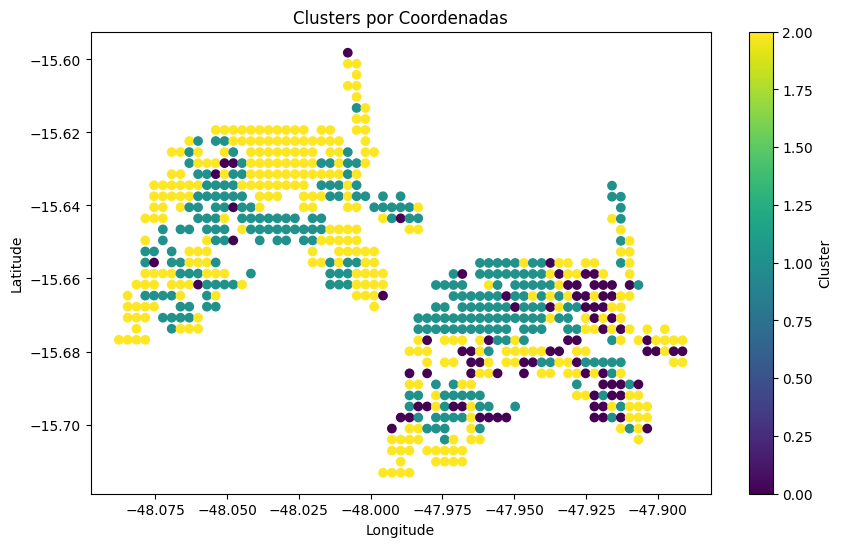

In [ ]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Carregar o arquivo CSV com as coordenadas
coordinates_file_path = 'nbr_with_lat_long.csv'  # Substitua pelo caminho do seu arquivo CSV com lat e long
coordinates_df = pd.read_csv(coordinates_file_path)

# Extrair as coordenadas de latitude e longitude
latitudes = coordinates_df['lat']
longitudes = coordinates_df['long']

# Realizar PCA para reduzir a dimensionalidade das coordenadas para 2D (se necessário)
# Neste caso, estamos assumindo que as coordenadas lat e long já estão em 2D, então não é necessário PCA aqui.

# Realizar KMeans para encontrar clusters
num_clusters = 20
kmeans = KMeans(n_clusters=num_clusters)
clusters = cluster_classes

# Adicionar os clusters ao DataFrame
coordinates_df['Cluster'] = clusters

# Plotar os clusters usando as coordenadas
plt.figure(figsize=(10, 6))
scatter = plt.scatter(coordinates_df['long'], coordinates_df['lat'], c=coordinates_df['Cluster'], cmap='viridis')
plt.colorbar(label='Cluster')
plt.title('Clusters por Coordenadas')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()
